In [1]:
import ml_mr.simulation as mr_sim
import numpy as np
import matplotlib.pyplot as plt

# Serialization needs to use dill instead of pickle
# if custom functions are used.
import dill as pickle

In [2]:
sim = mr_sim.Simulation(100_000)

sim.parameters["h2"] = 0.2
sim.parameters["n_variants"] = 15

sim.parameters["ux_effect"] = 0.25
sim.parameters["uy_effect"] = -0.7
sim.parameters["xy_effect"] = 0.3  # Target parameter

# Noise
sim.parameters["x_e_std"] = 1
sim.parameters["y_e_std"] = 1

In [3]:
# Standard normal for the confounder
sim.add_variable(mr_sim.Normal("u", 0, 1))

# We generate the variant frequencies "outside" of
# the simulation model because it's not very important.
# This could also be done using real simulation variables
# to ensure resampling.
# We still record them as (fixed) simulation parameters.
@mr_sim.variable
def variant_frequencies(sim):
    return np.random.uniform(
    0.05,
    0.5 - 0.05,
    size=sim.get_sim_parameter("n_variants")
)
sim.add_sim_parameter(variant_frequencies)

freqs = sim.parameters["variant_frequencies"]
# We now simulate independant genetic variants.
for i in range(sim.parameters["n_variants"]):
    variant = mr_sim.Variant(f"v{i+1}", freqs[i])
    sim.add_variable(variant)

# We simulate variant effects.
sim.add_sim_parameter(
    mr_sim.Normal(
        "gx_effects",
        mu=0,
        sigma=np.sqrt(sim.parameters["h2"] / sim.parameters["n_variants"]),
        size=sim.parameters["n_variants"]
    )
)
    
# We now have everything to simulate the exposure.
@mr_sim.variable
def exposure(sim):
    variant_effects = sim.parameters["gx_effects"]
    
    x = 0
    for i in range(sim.parameters["n_variants"]):
        variant = sim.get_variable_data(f"v{i+1}")
        effect = variant_effects[i]
        
        x += effect * variant
    
    # Add effect of counfounder.
    x += sim.parameters["ux_effect"] * sim.get_variable_data("u")
    
    # Add residual noise.
    x += np.random.normal(0, scale=sim.parameters["x_e_std"], size=sim.n)
    
    return x
    

# And the outcome.
@mr_sim.variable
def outcome(sim):
    return (
        sim.parameters["xy_effect"] * sim.get_variable_data("exposure") +
        sim.parameters["uy_effect"] * sim.get_variable_data("u") +
        np.random.normal(0, scale=sim.parameters["y_e_std"], size=sim.n)
    )


sim.add_variable(exposure)
sim.add_variable(outcome)

In [4]:
# Simulations can be saved to disk as pairs of JSON + CSV files.
# The JSON contains simulation parameters and the CSV files contains
# simulated data.
sim.save(0)

# The resample method can be used to run the simulation again.
sim.resample()
sim.save(1)

In [10]:
# The individual level data is stored as a pandas dataframe.
sim._data

,u,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,exposure,outcome
0,0.144772,0,0,0,0,0,0,0,1,0,0,0,1,2,1,0,-0.650906,-0.472321
1,1.076053,0,0,1,1,0,0,0,0,0,1,1,1,2,1,0,-0.442942,-1.209632
2,0.198898,1,0,0,1,0,0,1,1,0,1,1,0,1,0,0,0.738258,0.327934
3,-0.157007,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,3.120881,-0.265183
4,-0.128099,0,0,1,1,1,0,0,1,0,0,0,1,2,2,0,-0.507506,0.085597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.256818,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0.509631,0.651086
99996,0.364526,0,0,1,1,1,0,0,0,1,0,0,1,0,2,0,-1.019058,0.284462
99997,-0.315693,0,0,1,1,2,0,0,0,1,1,1,1,0,1,0,-1.155655,0.278024
99998,-1.347473,0,0,0,1,0,0,1,1,1,1,1,0,0,2,0,-0.591726,1.601623


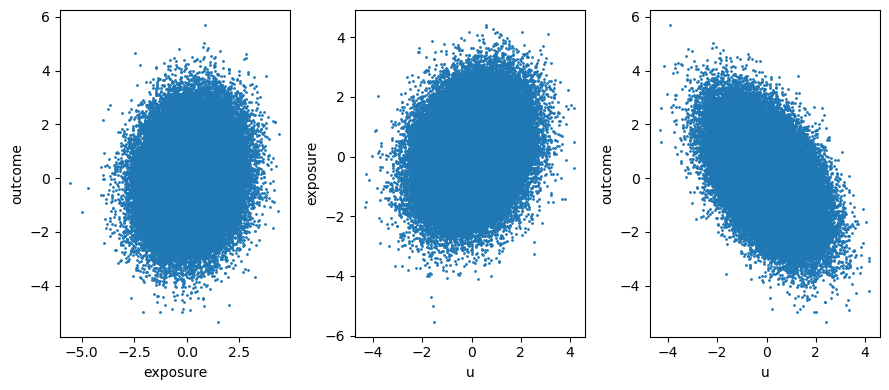

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(9, 4))

pairs = (
    ("exposure", "outcome"),
    ("u", "exposure"),
    ("u", "outcome")
)

for i, (x, y) in enumerate(pairs):
    axes[i].scatter(sim.get_variable_data(x), sim.get_variable_data(y), s=1)
    axes[i].set_xlabel(x)
    axes[i].set_ylabel(y)
    
plt.tight_layout()

In [11]:
# Simulations can be saved using the "dill" package.
# This allows easy sharing of simulation models.
# The original data will be saved.
sim.save_pickle("sim.pkl")
sim2 = mr_sim.Simulation.load_pickle("sim.pkl")
sim2._data

,u,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,exposure,outcome
0,0.144772,0,0,0,0,0,0,0,1,0,0,0,1,2,1,0,-0.650906,-0.472321
1,1.076053,0,0,1,1,0,0,0,0,0,1,1,1,2,1,0,-0.442942,-1.209632
2,0.198898,1,0,0,1,0,0,1,1,0,1,1,0,1,0,0,0.738258,0.327934
3,-0.157007,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,3.120881,-0.265183
4,-0.128099,0,0,1,1,1,0,0,1,0,0,0,1,2,2,0,-0.507506,0.085597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.256818,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0.509631,0.651086
99996,0.364526,0,0,1,1,1,0,0,0,1,0,0,1,0,2,0,-1.019058,0.284462
99997,-0.315693,0,0,1,1,2,0,0,0,1,1,1,1,0,1,0,-1.155655,0.278024
99998,-1.347473,0,0,0,1,0,0,1,1,1,1,1,0,0,2,0,-0.591726,1.601623


In [12]:
# And resampling should also work as expected!
sim2.resample()
sim2._data

,u,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,exposure,outcome
0,-0.408011,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0.163646,0.577006
1,0.335223,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0.494249,0.794292
2,-1.558948,0,0,0,0,0,0,1,1,1,1,0,1,1,2,0,0.481771,1.502278
3,-0.842354,0,0,1,2,0,0,0,1,0,1,1,2,1,1,0,0.516322,-0.897793
4,-0.023530,0,0,0,1,1,0,0,1,0,0,0,1,1,0,0,-1.119837,-1.438505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.182652,0,0,0,1,0,1,1,0,1,0,0,0,0,1,2,-0.879598,-1.660403
99996,1.671176,0,0,1,2,0,0,0,1,0,1,1,1,1,1,1,-0.937765,-2.860593
99997,-0.098628,0,0,1,1,0,0,0,1,0,0,0,0,1,0,1,1.747352,0.523111
99998,1.387000,0,0,2,1,0,0,1,0,2,0,1,1,0,2,0,0.781381,-1.431360
